using vader, roberta pretrained model and hugging face pipeline

Import data and NLTK basics

In [64]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import random
import nltk
nltk.download('punkt')  # Ensure the standard punkt tokenizer is installed
nltk.download('averaged_perceptron_tagger')  # Sometimes required for tokenization
nltk.download('wordnet')





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [65]:
df = pd.read_csv('hate_train.csv')
print(df.shape)
print(df.head(500))

(9000, 2)
                                                  text  label
0    @user nice new signage. Are you not concerned ...      0
1    A woman who you fucked multiple times saying y...      1
2    @user @user real talk do you have eyes or were...      1
3    your girlfriend lookin at me like a groupie in...      1
4                          Hysterical woman like @user      0
..                                                 ...    ...
495  @user Julian, you are currently hiding in a cu...      0
496  honey, it's not you vs. skank. It's you versus...      0
497  @user you are a big piece of white trash you f...      0
498  Mr Shorter - scum bag posting things like this...      0
499  #WakeUpAmerica~> #WalkAwayFromDemocrats @user ...      1

[500 rows x 2 columns]


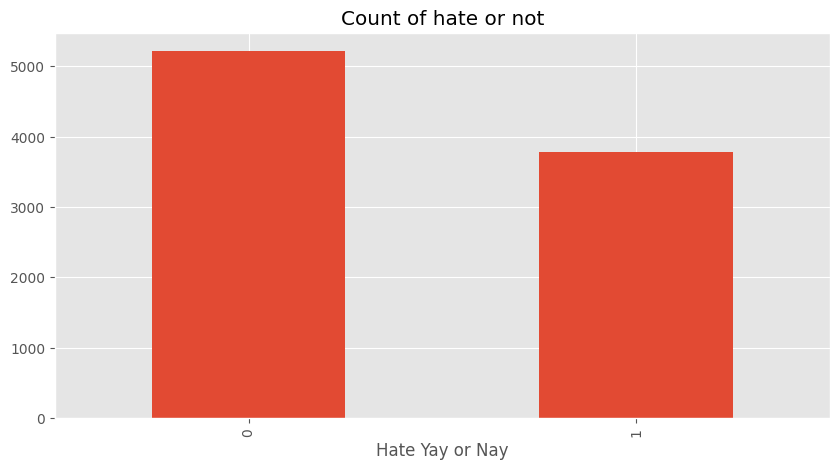

In [66]:
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of hate or not',
          figsize=(10, 5))
ax.set_xlabel('Hate Yay or Nay')
plt.show()

In [67]:
example = df['text'][random.randint(0, 500)]
print(example)

@user @user @user you can state what you want. But dont bitch when you are called out for perpetuating rape culture.


In [68]:
tokens = nltk.word_tokenize(example)
print(tokens[:10])


['@', 'user', '@', 'user', '@', 'user', 'you', 'can', 'state', 'what']


In [69]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('@', 'NNS'),
 ('user', 'VBP'),
 ('@', 'NNP'),
 ('user', 'NNP'),
 ('@', 'NNP'),
 ('user', 'IN'),
 ('you', 'PRP'),
 ('can', 'MD'),
 ('state', 'NN'),
 ('what', 'WP')]

In [70]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  @/NNS
  user/VBP
  @/NNP
  user/NNP
  @/NNP
  user/IN
  you/PRP
  can/MD
  state/NN
  what/WP
  you/PRP
  want/VBP
  ./.
  But/CC
  dont/JJ
  bitch/NN
  when/WRB
  you/PRP
  are/VBP
  called/VBN
  out/RP
  for/IN
  perpetuating/VBG
  rape/NN
  culture/NN
  ./.)


Pre Processing


In [71]:
import string

import re

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import contractions


In [72]:
def remove_hyperlinks_marks_styles(text):
    new_text = re.sub(r'^RT[\s]', '', text)
    new_text = re.sub(r'@\S+', '', new_text)
    new_text = re.sub(r'https?:\/\/.*[\r\n]*','', new_text)
    new_text = re.sub(r'#', '', new_text)

    return new_text
    

In [73]:
def tokenize_text(text):

    text_tokens = nltk.word_tokenize(text)

    return text_tokens


In [74]:
nltk.download('stopwords')

stopwords_english = stopwords.words('english')

punctuations = string.punctuation

def remove_punctuations_stopwords(text_tokens):

    text_clean = []

    for word in text_tokens:
        if (word not in stopwords_english and word not in punctuations):
            text_clean.append(word)

    return text_clean


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
def expand_contractions_in_text(text):
    return contractions.fix(text)

In [76]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif nltk_tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif nltk_tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun

In [77]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text_tokens):
    pos_tags = pos_tag(text_tokens)  # POS tagging
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]


In [78]:
def preprocess_text(text):
    text = remove_hyperlinks_marks_styles(text)  # Remove unnecessary elements
    text = expand_contractions_in_text(text)
    tokens = tokenize_text(text)  # Tokenize
    tokens = remove_punctuations_stopwords(tokens)  # Remove stopwords & punctuation
    tokens = lemmatize_text(tokens)  # Lemmatize with POS tagging
    return " ".join(tokens)  # Convert back to string if needed

preprocessing example

In [79]:
text = df['text'][random.randint(0, 500)]
processed_text = preprocess_text(text)

print("Original:", text)
print("Processed:", processed_text)

Original: @user you dumb cunt you trick 12 and 30 year old virgins into giving you money you fucking bitch. kys honest…
Processed: dumb cunt trick 12 30 year old virgin give money fuck bitch ky honest…


preprocessing all datasets

In [80]:
train_data = pd.read_csv('hate_train.csv')
val_data = pd.read_csv('hate_validation.csv')
test_data = pd.read_csv('hate_train.csv')


X_train, y_train = train_data['text'], train_data['label']
X_val, y_val = val_data['text'], val_data['label']
X_test, y_test = test_data['text'], test_data['label']

In [81]:
# Ensure the text column is a string and handle NaNs
X_train = X_train.astype(str).fillna('')
X_val = X_val.astype(str).fillna('')
X_test = X_test.astype(str).fillna('')

X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)


In [82]:
print(X_train)

0       nice new signage Are concern Beatlemania -styl...
1       A woman fuck multiple time say yo dick small c...
2                           real talk eye gouge rapefugee
3                    girlfriend lookin like groupie bitch
4                                   Hysterical woman like
                              ...                        
8995    Oooohhhh bitch even listen dead kennedy cunt l...
8996    Good Luck More Americans WalkAwayFromDemocrat ...
8997                                  Bitch keep stop try
8998    Japan always operate premise mass migration ra...
8999    hi Best l see someone fuck girl comment bad pi...
Name: text, Length: 9000, dtype: object


Naive Bayes Model

Converting text into numerical features using TF-IDF

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.8) 


In [84]:
# Fit on training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform validation and test data
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [85]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_curve

In [86]:
model = MultinomialNB()

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5,2.0, 5.0, 7.5, 10],  # Smoothing parameter
    'fit_prior': [True, False]      # Whether to learn class prior probabilities
}

# Track the best model and score
best_score = 0
best_params = {}


In [87]:
for alpha in param_grid['alpha']:
    for fit_prior in param_grid['fit_prior']:
        # Set model parameters
        model.set_params(alpha=alpha, fit_prior=fit_prior)
        
        # Train on the training set
        model.fit(X_train_tfidf, y_train)
        
        # Evaluate on the validation set
        val_predictions = model.predict(X_val_tfidf)
        val_score = accuracy_score(y_val, val_predictions)
        
        # Update best model if needed
        if val_score > best_score:
            best_score = val_score
            best_params = {'alpha': alpha, 'fit_prior': fit_prior}

print(f"Best Validation Accuracy: {best_score}")
print(f"Best Hyperparameters: {best_params}")

Best Validation Accuracy: 0.742
Best Hyperparameters: {'alpha': 0.5, 'fit_prior': True}


In [88]:
# Evaluate on Test Set
y_test_pred = model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)


f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1}")


Test Accuracy: 0.8253333333333334
Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      5217
           1       0.83      0.73      0.78      3783

    accuracy                           0.83      9000
   macro avg       0.83      0.81      0.82      9000
weighted avg       0.83      0.83      0.82      9000

Confusion Matrix:
 [[4671  546]
 [1026 2757]]
F1 Score: 0.7781541066892464


Neural Network Model


preprocessing

In [103]:

def nn_preprocess_text(text, remove_stopwords=True):
    # Lowercase the text
    text = text.lower()
    
    # Remove hyperlinks etc.

    text = remove_hyperlinks_marks_styles(text)

    text = expand_contractions_in_text(text)

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    
    #Remove stopwords
    if remove_stopwords:
        text = ' '.join(word for word in text.split() if word not in stopwords_english)
    
    return text

inputs

In [104]:
import tensorflow as tf

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


In [106]:
nn_train_data = pd.read_csv('hate_train.csv')
nn_val_data = pd.read_csv('hate_validation.csv')
nn_test_data = pd.read_csv('hate_train.csv')


nn_X_train, nn_y_train = nn_train_data['text'], nn_train_data['label']
nn_X_val, nn_y_val = nn_val_data['text'], nn_val_data['label']
nn_X_test, nn_y_test = nn_test_data['text'], nn_test_data['label']

In [107]:
# Ensure the text column is a string and handle NaNs
nn_X_train = nn_X_train.astype(str).fillna('')
nn_X_val = nn_X_val.astype(str).fillna('')
nn_X_test = nn_X_test.astype(str).fillna('')

nn_X_train = nn_X_train.apply(nn_preprocess_text)
nn_X_val = nn_X_val.apply(nn_preprocess_text)
nn_X_test = nn_X_test.apply(nn_preprocess_text)

In [108]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

nn_X_train_seq = tokenizer.texts_to_sequences(nn_X_train)
nn_X_val_seq = tokenizer.texts_to_sequences(nn_X_val)
nn_X_test_seq = tokenizer.texts_to_sequences(nn_X_test)

In [109]:
# Padding pre-tokenized sequences
max_sequence_length = 100

nn_X_train_padded = pad_sequences(nn_X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
nn_X_val_padded = pad_sequences(nn_X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
nn_X_test_padded = pad_sequences(nn_X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')


In [ ]:
# Build LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=100),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
# Train model
model.fit(nn_X_train_padded, y_train, validation_data=(nn_X_val_padded, y_val), epochs=15, batch_size=32)


Epoch 1/5
231/282 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5860 - loss: 0.6824

KeyboardInterrupt: 

In [ ]:
# Evaluate model
y_pred = (model.predict(nn_X_test_padded) > 0.5).astype('int32')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      5217
           1       0.00      0.00      0.00      3783

    accuracy                           0.58      9000
   macro avg       0.29      0.50      0.37      9000
weighted avg       0.34      0.58      0.43      9000

[[5217    0]
 [3783    0]]
Accuracy: 0.5796666666666667


C:\Users\RajBu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RajBu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RajBu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati